<a href="https://colab.research.google.com/github/Vesalon/xla-nmf/blob/main/notebooks/green_minimization_fides.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#!pip install fides

In [16]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np

from src.hnmf_optimizer import HNMFOptimizer
from src.clusts import result_analysis
from green_model import reconstruct_general, gen_init_params,  gen_bounds, clustering_preprocess


# set true variables

In [17]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# The amplitudes of the original sources

# 2 sources 
As = np.array([0.5, 0.7])
# # positions of the source
Xs = np.array([
    [-0.1, -0.2],
    [-0.9, -0.8]
])



# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

# positions of the detectors
Xd = np.array([
    [0, 0],
    [-0.5, -0.5],
    [0.5, 0.5],
    [0.5, -0.5]
])


# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4


# NMF run

In [18]:
# generate observations from target variables with small noise

noise_level = 1e-4
observations = reconstruct_general(As, Xs, Ts, Xd, t, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise


In [19]:
green_opt = HNMFOptimizer(
    model_fn = reconstruct_general,
    param_generator = gen_init_params,
    bound_generator = gen_bounds,
    input_args = ('t',),
    param_args = ('A_s', 'X_s', 'U', 'D'),
    constants = {'T_s': Ts, 'X_d': Xd},
    min_k = 1,
    max_k = 7,
    nsim = 100
)

res = green_opt(t, observations)
Forclusts = clustering_preprocess(res)

Forclusts = Forclusts.groupby('num_sources', group_keys=False).apply(lambda group: result_analysis(
    group['points'].sum(),
    group['normF'].mean(),
    observations.size,
    group['num_sources'].iloc[0]
))

SIMULATIONS FOR 1 SOURCES TOOK 15.248880386352539 SECONDS
SIMULATIONS FOR 2 SOURCES TOOK 30.418222427368164 SECONDS
SIMULATIONS FOR 3 SOURCES TOOK 50.324748516082764 SECONDS
SIMULATIONS FOR 4 SOURCES TOOK 65.65213823318481 SECONDS
SIMULATIONS FOR 5 SOURCES TOOK 78.41714453697205 SECONDS
SIMULATIONS FOR 6 SOURCES TOOK 81.95866537094116 SECONDS
SIMULATIONS FOR 7 SOURCES TOOK 84.27055931091309 SECONDS
Clustering  2
Clustering  3
Clustering  4
Clustering  5
Clustering  6
Clustering  7


In [20]:
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-1003.231721,1.000000,1.000000,13.831822,"[0.5135318102517922, -0.3519213119433905, -0.4..."
0,2,-3403.543057,1.000000,1.000000,0.007595,"[[0.49969419980858865, 0.7002283697103674], [-..."
0,3,inf,0.450488,-0.073062,0.007805,"[[0.43828235147534644, 0.6290609926331477, 0.3..."
0,4,inf,0.139116,-0.728891,0.008777,"[[0.4103665731535977, 0.29499084219963206, 0.4..."
0,5,inf,0.131475,-0.774680,0.009274,"[[0.33964656228724827, 0.32462907888728504, 0...."
0,6,inf,0.001763,-0.816273,0.010289,"[[0.3256967158866266, 0.27892143971098005, 0.4..."
0,7,inf,-0.114325,-0.867687,0.011154,"[[0.31221699095554256, 0.12649248679302405, 0...."


In [21]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all, output_dir):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(output_dir+"Selection_plot.png")
    plt.show()

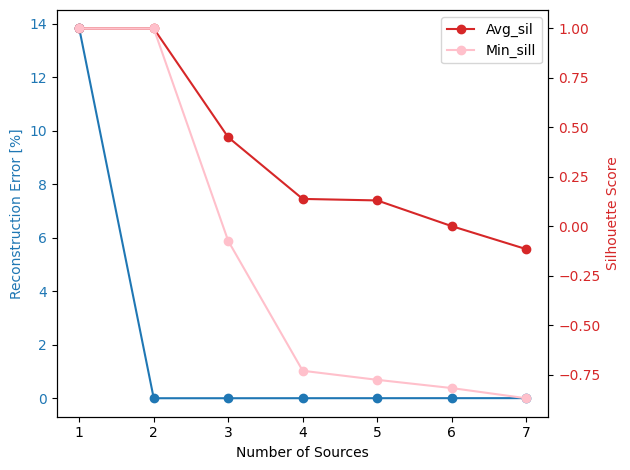

In [22]:
OUTPUTDIR = "Results/"
os.makedirs(OUTPUTDIR,exist_ok=True)

numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all,OUTPUTDIR)

In [23]:
Forclusts['centers'].iloc[1]

array([[ 0.4996942 ,  0.70022837],
       [-0.10014528, -0.89999728],
       [-0.20001009, -0.8000794 ],
       [ 0.05000082,  0.05000082],
       [ 0.00500007,  0.00500007],
       [ 0.0012506 ,  0.0012506 ]])

In [24]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.5,  0.7],
       [-0.1, -0.9],
       [-0.2, -0.8]])